# Polarisation des commentaires

In [1]:
#!pip install textblob
#!pip install textblob-fr

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob
from textblob_fr import PatternTagger, PatternAnalyzer
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yseul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
data = pd.read_csv("comments.csv")

## Calcul de polarités

Le module TextBlob est un module python de NLP utilisé pour l'analyse de sentiments et qui permet, entre autres, de calculer la polarité d'un texte. Celle-ci est définie par un nombre entre -1 et 1, et détermine le degré de satisfaction ou d'insatisfaction qui se dégage du texte. Plus la polaritée est proche de 1, plus le texte dégage un sentiment positif, et vice-versa.

Nous avons calculé la polarité de chaque commentaire de deux façons. Nous avons d'une part appliqué directement la fonction du module TextBlob qui nous intéresse au commentaire. D'autre part, nous avons découpé chaque commentaire en phrases, avant d'appliquer à chacune de celles-ci la fonction qui renvoie leur polarisation, puis d'en faire la moyenne sur toutes les phrases du commentaire.

In [5]:
def blober(text: str) -> float:
    '''
    Calcule la polarité d'un texte.
    
    Paramètres : 
    ----------
    text : str
        texte dont on veut mesurer la polarité
        
    Sortie :
    ----------
    float
        polarisation : score entre -1 et 1.
        Plus le score est proche de 1, plus le commentaire est positif.
        Plus il est proche de -1, plus le commentaire est négatif.
    '''
    return TextBlob(text, pos_tagger=PatternTagger(), analyzer=PatternAnalyzer()).sentiment[0]

blober = np.vectorize(blober)

def sentences(comment: str) -> list:
    '''
    Découpe un texte en phrases.
    
    Paramètres : 
    ----------
    comment : str
        texte dont on veut extraire les phrases
        
    Sortie :
    ----------
    list[str]
        liste des phrases du texte
    '''
    tokenizer = nltk.data.load('tokenizers/punkt/french.pickle')
    return tokenizer.tokenize(comment)

def polarisation(comment: str) -> float:
    '''
    Calcule la polarisation d'un commentaire en calculant d'abord la polarisation de chacune de ses 
    phrases et en en faisant la moyenne
    
    Paramètres : 
    ----------
    comment : str
        texte dont on veut la polarisation
        
    Sortie :
    ----------
    float
        moyenne des polarisations des phrases du texte
    '''
    s = sentences(comment)
    return np.mean(blober(s))

polarisation = np.vectorize(polarisation)

Nous avons ensuite ajouté 2 nouvelles colonnes à la base de données:

   - Polarity : polarité de chaque commentaire, calculée sur le commentaire entier directement
    
   - sentencesPolarity : polarité de chaque commentaire, calculée en prenant la moyenne des polarités sur chaque phrase que comporte le commentaire.

In [6]:
data["Polarity"] = data.loc[:,['textClean']].apply(blober)
data["sentencesPolarity"] = data.loc[:,['textClean']].apply(polarisation)

Création d'une colonne de numéros des vidéos.

In [7]:
data['DBY'] = data.loc[:,['videoTitle']].apply(np.vectorize(lambda string : string[-7:]))

## Analyse des polarités

Dans un premier temps, on s'intéresse à la répartition des polarités pour une vidéo, ici la vidéo "Comment ces champis nous ont façonnés - DBY #76".

In [8]:
data.loc[data['DBY'] == "DBY #76", ['Polarity', 'sentencesPolarity']].describe()

,Polarity,sentencesPolarity
count,100.000000,100.000000
mean,0.358376,0.308844
std,0.291595,0.259852
min,-0.200000,-0.106000
25%,0.145833,0.121979
50%,0.343125,0.252500
75%,0.499766,0.450833
max,1.000000,1.000000


On voit que pour les deux types de polarité, il y a très peu de valeurs négatives. Cela implique que les commentaires de cette vidéo sont pour la plupart perçus comme positifs.
Les écarts type sont de 0.29 et 0.26, ce qui est assez élevé pour des valeurs de polarités allant entre -0.2 (-0.1 pour "sentencesPolarity") et 1. Ainsi, les commentaires de cette vidéo dégagent plusieurs degrés de satisfaction, allant de neutre à très satisfait. La moitié d'entre eux sont relativement satisfaits, et ont une polarité se trouvant entre 0.15 et 0.50 (0.12 et 0.45 pour sentencesPolarity).

Cela se perçoit bien sur les histogrammes ci-dessous:

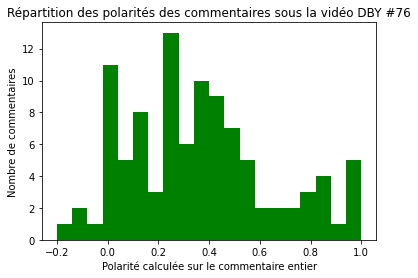

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

data.loc[data['DBY'] == "DBY #76", 'Polarity'].plot.density(ax = axs[0])
data.loc[data['DBY'] == "DBY #76", 'Polarity'].plot.hist(bins=20, density=True, ax = axs[0])

axs[0].set_xlabel("Polarité calculée sur le commentaire entier")
axs[0].set_ylabel("Nombre de commentaires (renormalisé)")
axs[0].set_title("Répartition des polarités des commentaires sous la vidéo DBY #76")

data.loc[data['DBY'] == "DBY #76", 'sentencesPolarity'].plot.density(ax=axs[1])
data.loc[data['DBY'] == "DBY #76", 'sentencesPolarity'].plot.hist(bins=20, density=True, ax=axs[1])

axs[1].set_xlabel("Polarité calculée sur les phrases du commentaire prises une à une")
axs[1].set_ylabel("Nombre de commentaires (renormalisé)")
axs[1].set_title("Répartition des polarités des commentaires sous la vidéo DBY #76")

plt.show()

In [ ]:
data2 = data.sort_values("Polarity").set_index("Polarity")["commentLikeCount"]

fig, axs = plt.subplots(2, 2, figsize=(20, 10))

for i, ax in enumerate(np.array(axs).flatten()):
    plot_data = data2.iloc[500*i:500*(i+1)]
    plot_data.plot.density(ax=ax)
    plot_data.plot.hist(bins=[0]+[200 + 50*i for i in range(100)], density=True, ax=ax)
    ax.set_xlabel("Nombre de likes reçus par le commentaire")
    ax.set_ylabel("Nombre de commentaires (renormalisé)")
    ax.set_title("Répartition du nombre de likes reçus par les commentaires renvoyant un sentiment " + ["négatif ou neutre", "légèrement positif", "positif", "très positif"][i])

Sur chacun des graphiques, la première barre représente les commentaires ayant reçu moins de 200 likes. On considère qu'un commentaire a "percé" lorsqu'il a reçu plus de 200 likes. Il semble que les commentaires les moins positif (ce qui ont la polarité la plus faible) sont ceux qui ont le plus de chance d'avoir du succès. Cela pourrait être dû au fait que les commentaires émettant un avis, qui sont ceux qui reçoivent le plus de likes, sont plutôt neutres, contrairement à ceux qui indiquent que la vidéo a plu, qui dégagent un sentiment positif.

**Comparaison des vidéos entre elles**

Nous avons ensuite fait la moyenne des polarités sur les 100 commentaires de chaque vidéo, ce qui nous permet de comparer les vidéos entre elles.

In [11]:
datapol = data.groupby(['DBY']).mean().sort_values('Polarity', ascending = False)
datapol.loc[:, ['videoLikeCount', 'Polarity', 'sentencesPolarity']]

,videoLikeCount,Polarity,sentencesPolarity
DBY,,,
DBY #72,87990.0,0.391309,0.378558
DBY #81,40049.0,0.389876,0.322359
DBY #74,50146.0,0.374054,0.324198
DBY #80,42480.0,0.363191,0.331241
DBY #76,47151.0,0.358376,0.308844
DBY#84,49600.0,0.353083,0.297797
DBY #87,34914.0,0.346008,0.299026
DBY #77,62564.0,0.339487,0.299937
DBY #82,46060.0,0.334684,0.296303


Tout d'abord, nous avons cherché à savoir si les résultats de polarisation restaient cohérents entre les deux méthodes utilisées.

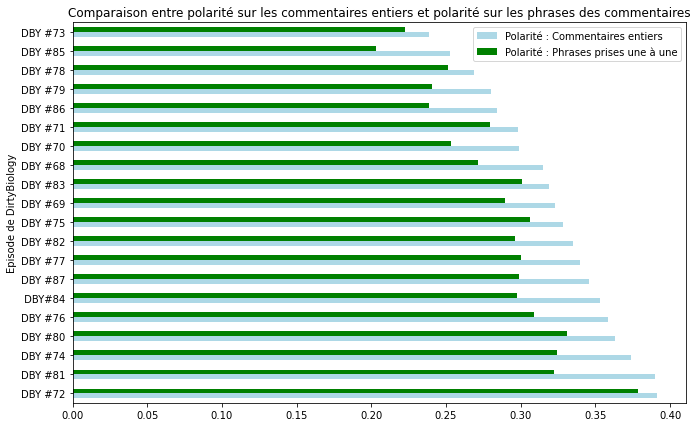

In [12]:
datapol.loc[:,['Polarity','sentencesPolarity']].plot(kind = 'barh', figsize = (11, 7), color = ['lightblue', 'green'], title = 'Comparaison entre polarité sur les commentaires entiers et polarité sur les phrases des commentaires', xlabel = 'Episode de DirtyBiology')
plt.legend(labels = ['Polarité : Commentaires entiers', 'Polarité : Phrases prises une à une'])
plt.savefig("./graphs/comparaison_polarites")
plt.show()

L'ordre des vidéos change un peu selon la définition que l'on utilise pour la polarité, mais les deux définitions semblent tout de même corrélées (globalement, la polarité prise sur chaque phrase augmente avec celle prise sur le commentaire entier).

Dans la suite, on garde la polarité sur le commentaire entier.

La polarité est un témoin du succès qu'a eu une vidéo. On cherche à présent à la comparer à un autre marqueur de ce succès, à savoir le ratio de "likes" qu'à reçu une vidéo par rapport à son nombre de vues.

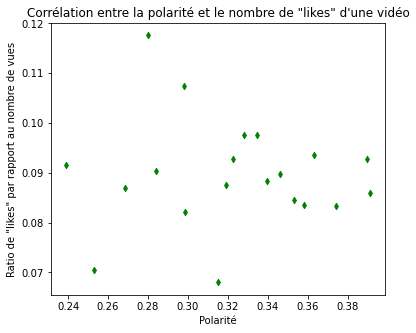

In [13]:
datapol['likeRatio'] = datapol.loc[:,'videoLikeCount'].divide(datapol.loc[:,'viewCount'])
datapol.plot(kind = 'scatter', x = 'Polarity', y = 'likeRatio',figsize = (6, 5), marker = 'd', xlabel = 'Polarité', color = 'green', ylabel = 'Ratio de \"likes\" par rapport au nombre de vues', title = 'Corrélation entre la polarité et le nombre de \"likes\" d\'une vidéo')
plt.savefig("./graphs/comparaison_polarite_likes")
plt.show()

Il semble ne pas y avoir de corrélation entre ces deux marqueurs. Cela peut être dû au fait que la polarisation ne soit pas très précise, ou que les personnes qui commentent les vidéos n'aient pas le même profil que ceux qui se contentent de "liker".